In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Math
from scipy.optimize import minimize
import scipy.optimize as opt
import emcee
import corner
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Text(0, 0.5, 'y')

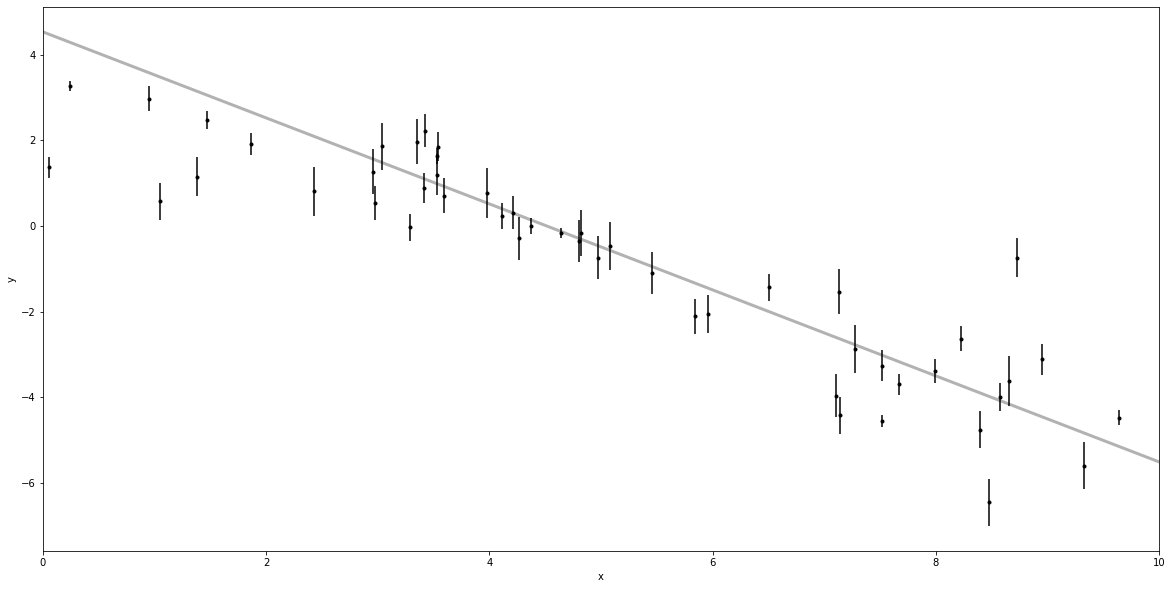

In [2]:
#data
# Choose the "true" parameters.
m_true = -1.003 #-0.9594
b_true = 4.528 # 4.294
f_true = 0.454 #0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [3]:
def model(Param , x=x):
    m, b, f = Param
    model = m * x + b
    model += np.abs(f * model)
    return model

In [35]:
def lnlike(Param, x, y):
    ymodel = model(Param , x)
    n = len(y)
    LnLike = -0.5 * n * np.log(sum(np.power((y - ymodel), 2)) / n) 
    return LnLike

In [81]:
def lnprior(Param):
    m, b, f = Param
    if -1.2<m<-0.4 and 2.0<b<5.8 and -0.25<f<0.3:
        return 0.0
    
    else:
        return -np.inf

In [82]:
def lnprob(Param, x, y):
    lp = lnprior(Param)
    if not lp == 0: 
        return -np.inf
    return lp + lnlike(Param, x, y)

In [83]:
nll = lambda *args: -lnlike(*args)
result = opt.minimize(nll, [m_true, b_true, f_true],
                      args=(x, y))
print(result['x'])

[-8.50966697e-01  3.47605464e+00 -2.29360963e-09]


In [84]:
nwalkers = 1500
niter = 2024
initial = np.array([-0.6, 4.1, 0.1])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]


In [85]:
def main(p0,nwalkers,niter,ndim,lnprob,data=(x,y)):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 1000)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [86]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,(x,y))

Running burn-in...
Running production...


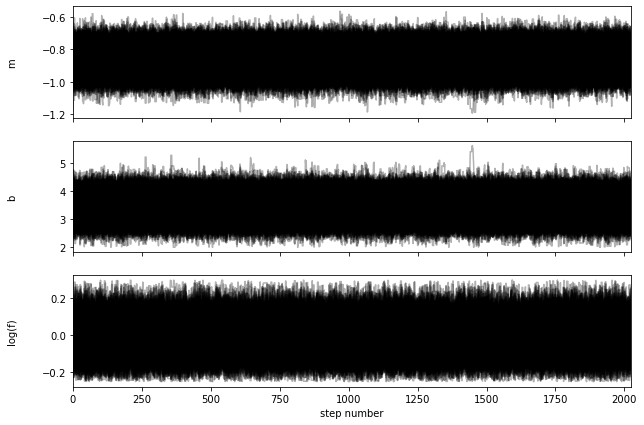

In [87]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [88]:
tau = sampler.get_autocorr_time()
print(tau)

[33.28798503 32.79297095 33.56169209]


In [89]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(192000, 3)


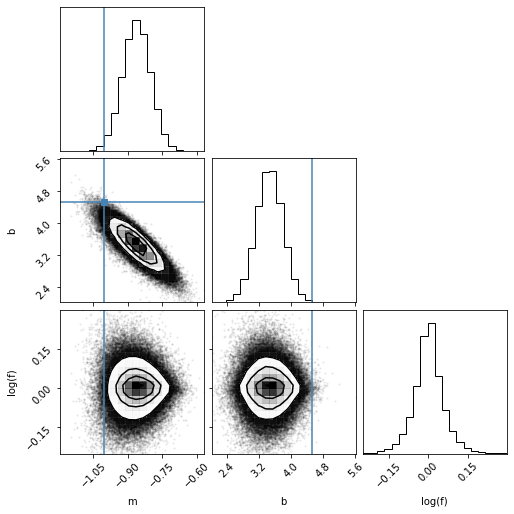

In [90]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [91]:
nll = lambda *args: -lnlike(*args)
soln = minimize(nll, initial, args=(x, y))
m_ml, b_ml, log_f_ml = soln.x

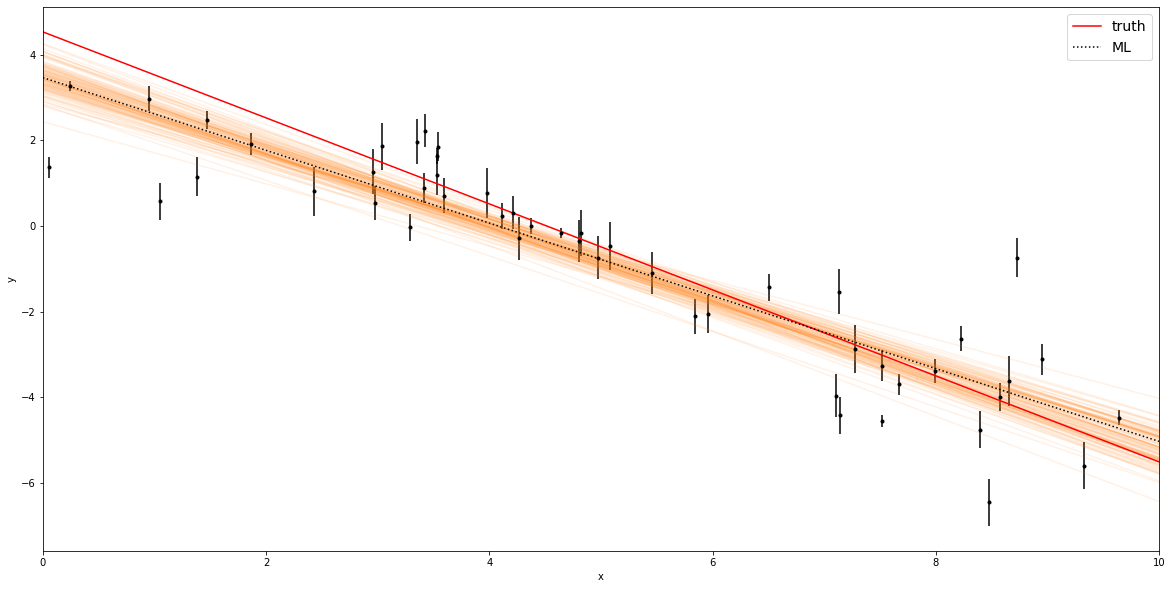

In [92]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "r", label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [93]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Math
from scipy.special import gamma

In [49]:
class GIUH:
    def __init__(self, Qmax, v, m_Rb, m_Ra, m_Rl, L, t):
        #self.Q = Q
        self.Qmax = Qmax
        self.v = v
        self.m_Rb = m_Rb
        self.m_Ra = m_Rb
        self.m_Rl = m_Rl
        self.L = L
        self.t = t
        self.comp_u = []
    
    def GIUH_vars(self):
        self.a = 3.29 * ((self.Rb / self.Ra) ** 0.78) * (self.Rl ** 0.07)
        self.k = 0.7 * ((self.Ra / (self.Rb * self.Rl)) ** 0.48) * L / self.v
        return 
    
    def GIUH_Rs(self):
        self.Rb = 1 / (10 ** m_Rb)
        self.Ra = 10 ** m_Ra
        self.Rl = 10 ** m_Rl
        return 
    
    def GIUH_U(self):
        self.u = ((self.time / self.k) ** (self.a - 1)) * np.exp(-self.time / self.k) / (self.k * gamma(self.a))
        return 

    def GIUH_qp(self):
        self.qp = (1.31 / (self.L / 1000)) * (self.Rl ** 0.43) * self.v
        return 

    def GIUH_tp(self):
        self.tp = 0.44 * ((self.Ra / self.Rb ) ** 0.55) * ((self.L / 1000)  ** (-0.38)) * (self.L / 1000) / self.v
        return 
    
    def GIUH_loop(self):
        for i in range(len(t)):
            self.time = t[i]
            self.GIUH_U()
            self.comp_u.append(self.u)
            
    def GIUH_plot(self):
        plt.plot(self.t, self.comp_u, linewidth=5.0)
        plt.xlabel("Time(s)", size = 30)
        plt.ylabel("GIUH", size = 30)
        plt.xticks(size = 20)
        plt.yticks(size = 20)
        plt.grid(True)
        plt.show()
    

In [ ]:
# Q =
Qmax = 207 * 0.028316846592 # 6/17/2000 #63.41 * 0.028316846592      # m^3/s
tp = 59 / 60 # 59
v = 0.44 * ((giuh.Ra / giuh.Rb ) ** 0.55) * ((giuh.L/1000)  ** (-0.38)) * (giuh.L/1000) / tp  # m/s
#v = 2.85215 / (1000 * 3600)        
m_Ra = 0.716 #0.526
m_Rb = -0.664#-0.716
m_Rl = 0.463#0.134
L = 8141 #833                            # m
t = [i for i in range(40000)]
giuh = GIUH(Qmax, v, m_Rb, m_Ra, m_Rl, L, t)

In [ ]:
giuh.GIUH_Rs()
giuh.GIUH_vars()
giuh.GIUH_qp()
giuh.GIUH_tp()
giuh.GIUH_loop()

In [52]:
print("   Qmax of the GIUH: {:9.10f}".format(giuh.Qmax) + " m^3/s")
print("   Ra of the GIUH: {:9.10f}".format(giuh.Ra))
print("   Rb of the GIUH: {:8.4f}".format(giuh.Rb))
print("   Rl of the GIUH: {:9.10f}".format(giuh.Rl))
print("   L of the GIUH: {:8.4f}".format(giuh.L) + " m/s")
print("   k of the GIUH: {:9.10f}".format(giuh.k))
print("   a of the GIUH: {:8.4f}".format(giuh.a))
print("   peak discharge of the GIUH: {:9.10f}".format(giuh.qp))
print("   The time to peak of the GIUH: {:8.4f}".format(giuh.tp))

   Qmax of the GIUH: 5.8615872445 m^3/s
   Ra of the GIUH: 5.1999599653
   Rb of the GIUH:   4.6132
   Rl of the GIUH: 2.9040226545
   L of the GIUH: 8141.0000 m/s
   k of the GIUH: 2552.6690928493
   a of the GIUH:   3.2288
   peak discharge of the GIUH: 0.3607321212
   The time to peak of the GIUH:   1.2167


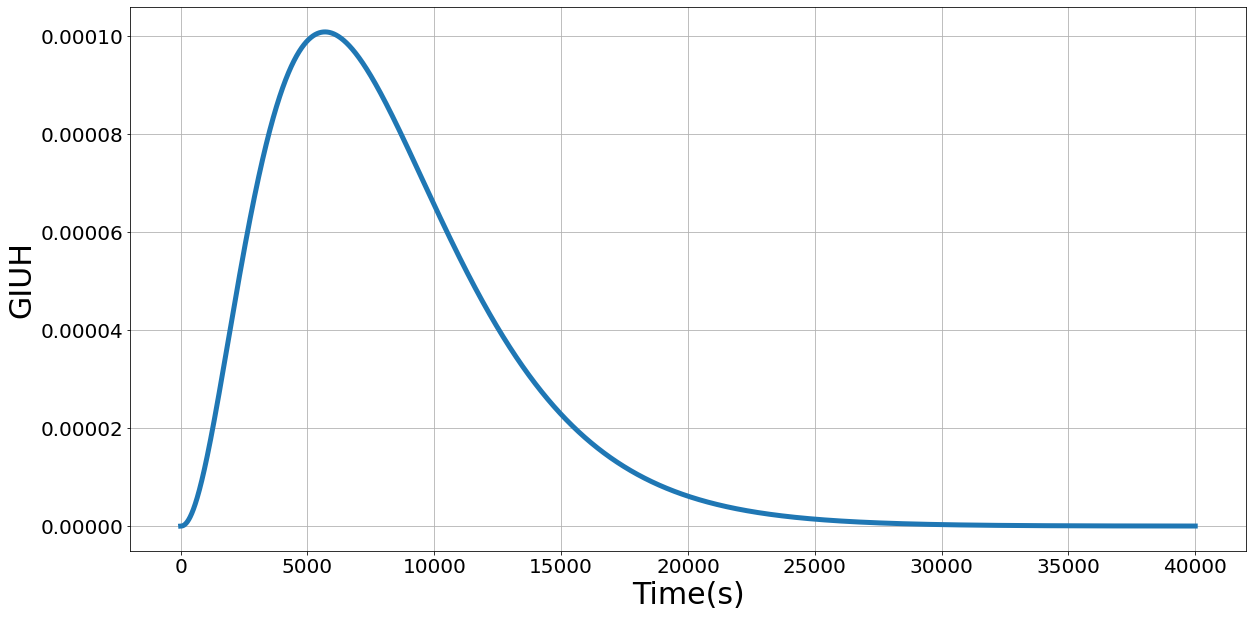

In [53]:
giuh.GIUH_plot()